In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!wget -q https://archive.apache.org/dist/spark/spark-2.2.3/spark-2.2.3-bin-hadoop2.7.tgz
!tar xf spark-2.2.3-bin-hadoop2.7.tgz
!pip install -q findspark

In [3]:
!ls

gdrive	sample_data  spark-2.2.3-bin-hadoop2.7	spark-2.2.3-bin-hadoop2.7.tgz


In [4]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

openjdk version "11.0.4" 2019-07-16
OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3)
OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)


In [5]:
!update-alternatives --config java

There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
* 0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
  2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [6]:
!java -version

openjdk version "1.8.0_222"
OpenJDK Runtime Environment (build 1.8.0_222-8u222-b10-1ubuntu1~18.04.1-b10)
OpenJDK 64-Bit Server VM (build 25.222-b10, mixed mode)


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.3-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

In [0]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

training_features = pd.read_csv("/content/gdrive/My Drive/project/training_features.csv",header =0)
training_labels = pd.read_csv("/content/gdrive/My Drive/project/training_labels.csv",header =0)
testing = pd.read_csv("/content/gdrive/My Drive/project/test_features.csv",header =0)
training = pd.concat([training_features,training_labels],axis = 1)

In [10]:
from sklearn.cluster import KMeans
X = pd.concat([training, testing],axis = 0)
X = X[['latitude', 'longitude']].values
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]
X.shape

(414, 2)

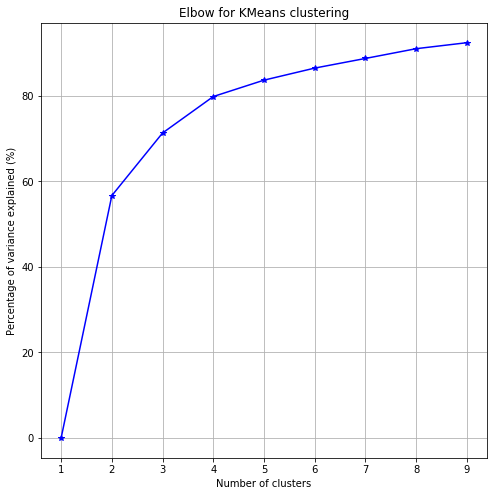

In [11]:
from scipy.spatial.distance import cdist, pdist
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.show()

plot_elbow(kmean, X)

In [12]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [13]:
kmeans.labels_.shape

(414,)

In [14]:
dff = pd.concat((training, pd.DataFrame(kmeans.labels_)), axis=1)
dff = dff.drop(["latitude","longitude"],axis = 1)
dff.columns = ['trans_date','house_age','distance_mrt','stores','house_price','dist']
df = dff.iloc[:289,:]
df.head()

,trans_date,house_age,distance_mrt,stores,house_price,dist
0,2013.500000,26.4,335.52730,6.0,38.1,2
1,2013.416667,6.4,90.45606,9.0,59.5,2
2,2013.333333,3.9,49.66105,8.0,56.8,0
3,2013.500000,23.0,3947.94500,0.0,25.3,1
4,2013.333333,39.7,333.36790,9.0,32.4,2


In [15]:
rows = pd.DataFrame(kmeans.labels_).iloc[290:,:]
testing.reset_index(drop=True, inplace=True)
rows.reset_index(drop=True, inplace=True)
dff1 = pd.concat([testing,rows], axis=1)
df1 = dff1.drop(["latitude","longitude"],axis = 1)
df1.columns = ['trans_date','house_age','distance_mrt','stores','dist']
df1.head()

,trans_date,house_age,distance_mrt,stores,dist
0,2012.833333,10.3,211.4473,1,1.0
1,2013.333333,24.0,4527.6870,0,2.0
2,2013.333333,34.5,324.9419,6,1.0
3,2013.333333,25.6,4519.6900,0,2.0
4,2013.500000,14.4,169.9803,1,0.0


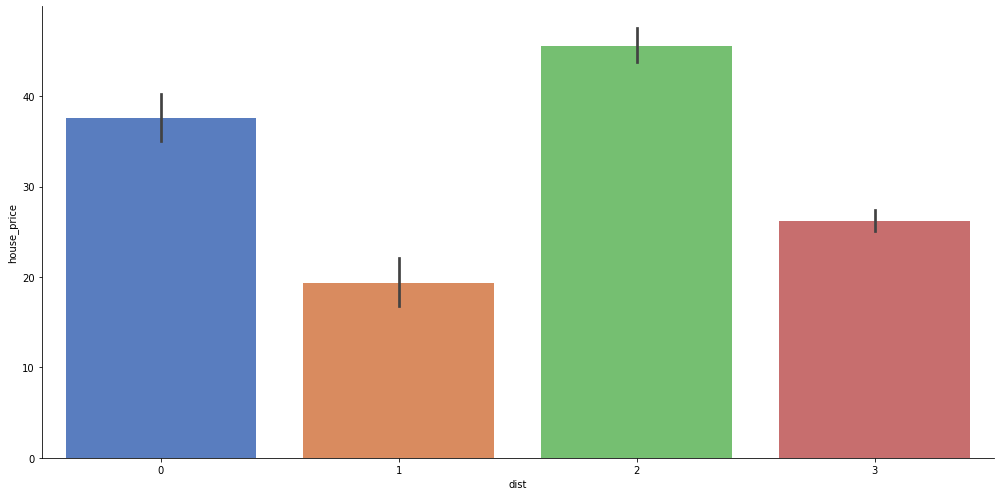

In [16]:
sns.factorplot(x='dist', 
               size= 7, 
               aspect= 2,
               data=df, 
               y ='house_price',
               kind='bar',
               palette = "muted")
plt.show()

In [17]:
df['house_price'].describe()

count    289.000000
mean      38.333218
std       13.824176
min       11.200000
25%       27.700000
50%       38.600000
75%       47.100000
max      117.500000
Name: house_price, dtype: float64

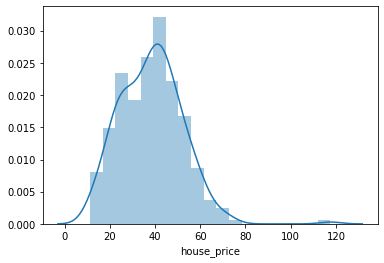

In [18]:
#histogram
sns.distplot(df['house_price'])

In [19]:
df.sort_values('house_price').tail(1)

,trans_date,house_age,distance_mrt,stores,house_price,dist
172,2013.333333,10.8,252.5822,1.0,117.5,2


In [0]:
df = df.drop(172, axis = 0)

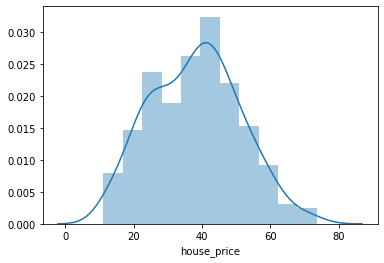

In [21]:
#histogram
sns.distplot(df['house_price'])

In [22]:
#skewness and kurtosis
print("Skewness: %f" % df['house_price'].skew())
print("Kurtosis: %f" % df['house_price'].kurt())

Skewness: 0.123865
Kurtosis: -0.485088


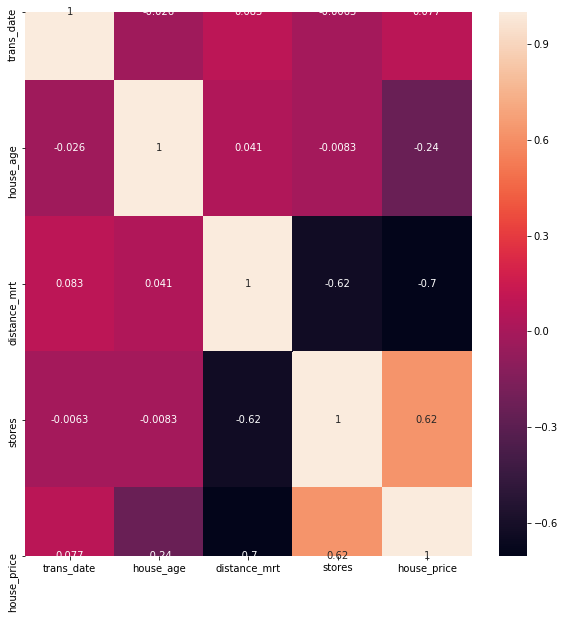

In [23]:
#correlation matrix
%matplotlib inline
corr = df.iloc[:,:-1].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr,annot = True,
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [24]:
df['trans_date'].describe()

count     288.000000
mean     2013.149016
std         0.282665
min      2012.666667
25%      2012.916667
50%      2013.166667
75%      2013.416667
max      2013.583333
Name: trans_date, dtype: float64

In [25]:
df = df.drop('trans_date',axis = 1)
df1 = df1.drop(['trans_date'],axis = 1)
df1.head()

,house_age,distance_mrt,stores,dist
0,10.3,211.4473,1,1.0
1,24.0,4527.6870,0,2.0
2,34.5,324.9419,6,1.0
3,25.6,4519.6900,0,2.0
4,14.4,169.9803,1,0.0


In [26]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 4 columns):
house_age       125 non-null float64
distance_mrt    125 non-null float64
stores          125 non-null int64
dist            124 non-null float64
dtypes: float64(3), int64(1)
memory usage: 4.0 KB


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 0 to 288
Data columns (total 5 columns):
house_age       288 non-null float64
distance_mrt    288 non-null float64
stores          288 non-null float64
house_price     288 non-null float64
dist            288 non-null int32
dtypes: float64(4), int32(1)
memory usage: 12.4 KB


In [28]:
df.astype({'stores': 'int64','dist': 'float64'}).dtypes

house_age       float64
distance_mrt    float64
stores            int64
house_price     float64
dist            float64
dtype: object

In [0]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("MLlib")
sc = SparkContext(conf=conf)
sc.setLogLevel("WARN")
spark = SparkSession(sc)

In [0]:
df = spark.createDataFrame(df)
df1 = spark.createDataFrame(df1)

In [31]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['house_age', 'distance_mrt', 'stores', 'dist'], outputCol = 'features')
vhouse_df = vectorAssembler.transform(df)
vhouse_df = vhouse_df.select(['features', 'house_price'])
vhouse_df.show(3)

+--------------------+-----------+
|            features|house_price|
+--------------------+-----------+
|[26.4,335.5273,6....|       38.1|
|[6.4,90.45606,9.0...|       59.5|
|[3.9,49.66105,8.0...|       56.8|
+--------------------+-----------+
only showing top 3 rows



In [32]:
df1 = vectorAssembler.transform(df1)
df1 = df1.select('features')
df1.show(3)

+--------------------+
|            features|
+--------------------+
|[10.3,211.4473,1....|
|[24.0,4527.687,0....|
|[34.5,324.9419,6....|
+--------------------+
only showing top 3 rows



In [0]:
splits = vhouse_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [34]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
lr = LinearRegression(featuresCol = 'features', labelCol='house_price', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)
lr_predictions = lr_model.transform(test_df)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="house_price",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

RMSE: 8.014455
r2: 0.625725
R Squared (R2) on test data = 0.510601
Root Mean Squared Error (RMSE) on test data = 8.83879


In [35]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","house_price","features").show()

+------------------+-----------+--------------------+
|        prediction|house_price|            features|
+------------------+-----------+--------------------+
|  49.3505180923011|       73.6|[0.0,292.9978,6.0...|
| 48.16419457295713|       45.4|[2.3,184.3302,6.0...|
| 44.78317958811956|       53.9|[2.7,533.4762,4.0...|
| 36.03365342811806|       28.4|[4.0,2147.376,3.0...|
| 35.87886893359153|       28.6|[4.0,2180.245,3.0...|
|  48.1534183611875|       63.2|[5.3,259.6607,6.0...|
| 52.91454500164515|       52.7|[5.9,90.45606,9.0...|
| 52.83789847876825|       58.0|[6.2,90.45606,9.0...|
| 52.61907926893826|       49.8|[7.1,379.5575,10....|
|45.418811406711114|       57.1|[7.1,451.2438,5.0...|
|33.593383092598366|       38.5|[9.0,1402.016,0.0...|
| 35.50197489676242|       43.5|[10.0,942.4664,0....|
|  35.2786687431959|       27.3|[10.4,2251.938,4....|
|  34.9199643963286|       28.8|[11.0,1712.632,2....|
| 49.56094794318227|       55.9|[11.6,201.8939,8....|
| 42.63353267489866|       4

In [36]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'house_price', maxIter=10)
gbt_model = gbt.fit(train_df)
gbt_evaluator = RegressionEvaluator(
    labelCol="house_price", predictionCol="prediction", metricName="rmse")
training_result = gbt_evaluator.evaluate(gbt_model.transform(train_df))
gbt_predictions = gbt_model.transform(test_df)
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on train data = %g" % training_result)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on train data = 3.83219
Root Mean Squared Error (RMSE) on test data = 6.67121


In [37]:
gbt_predictions.select('prediction', 'house_price', 'features').show()

+------------------+-----------+--------------------+
|        prediction|house_price|            features|
+------------------+-----------+--------------------+
| 67.79284226873276|       73.6|[0.0,292.9978,6.0...|
| 48.84405767566218|       45.4|[2.3,184.3302,6.0...|
| 51.56841099268822|       53.9|[2.7,533.4762,4.0...|
|27.704177919388716|       28.4|[4.0,2147.376,3.0...|
| 25.82315126765783|       28.6|[4.0,2180.245,3.0...|
|53.683742449577046|       63.2|[5.3,259.6607,6.0...|
| 58.34380631546664|       52.7|[5.9,90.45606,9.0...|
| 58.34380631546664|       58.0|[6.2,90.45606,9.0...|
| 62.73805911107387|       49.8|[7.1,379.5575,10....|
| 52.04241849271367|       57.1|[7.1,451.2438,5.0...|
|41.627768379560216|       38.5|[9.0,1402.016,0.0...|
|41.627768379560216|       43.5|[10.0,942.4664,0....|
| 25.16796944577128|       27.3|[10.4,2251.938,4....|
| 25.16796944577128|       28.8|[11.0,1712.632,2....|
|44.363217544864334|       55.9|[11.6,201.8939,8....|
|40.128508411405136|       4

In [38]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(featuresCol ='features', labelCol = 'house_price')
rf_model = rf.fit(train_df)
rf_evaluator = RegressionEvaluator(
    labelCol="house_price", predictionCol="prediction", metricName="rmse")
training_result = rf_evaluator.evaluate(rf_model.transform(train_df))
testing_result = rf_evaluator.evaluate(rf_model.transform(test_df))
print("Root Mean Squared Error (RMSE) on train data = %g" % training_result)
print("Root Mean Squared Error (RMSE) on test data = %g" % testing_result)

Root Mean Squared Error (RMSE) on train data = 4.70098
Root Mean Squared Error (RMSE) on test data = 6.43642


In [39]:
predictions = rf_model.transform(test_df)
predictions.select("prediction","house_price","features").show()

+------------------+-----------+--------------------+
|        prediction|house_price|            features|
+------------------+-----------+--------------------+
| 63.27446980796982|       73.6|[0.0,292.9978,6.0...|
| 49.65597865728601|       45.4|[2.3,184.3302,6.0...|
| 44.36568981276721|       53.9|[2.7,533.4762,4.0...|
| 29.05181922946082|       28.4|[4.0,2147.376,3.0...|
| 29.59128351517511|       28.6|[4.0,2180.245,3.0...|
| 54.25111851579351|       63.2|[5.3,259.6607,6.0...|
|  56.1827435064935|       52.7|[5.9,90.45606,9.0...|
|  56.1827435064935|       58.0|[6.2,90.45606,9.0...|
|  53.3606446053946|       49.8|[7.1,379.5575,10....|
| 47.61126071637341|       57.1|[7.1,451.2438,5.0...|
| 41.08869607592589|       38.5|[9.0,1402.016,0.0...|
| 40.56902940925922|       43.5|[10.0,942.4664,0....|
|27.806374544516125|       27.3|[10.4,2251.938,4....|
| 27.68593298607457|       28.8|[11.0,1712.632,2....|
| 44.21320113731298|       55.9|[11.6,201.8939,8....|
| 40.18134946124782|       4

In [0]:
#submit the rf prediction
rf_predictions = rf_model.transform(df1).select("prediction")
test = rf_predictions.toPandas()
test.to_csv("/content/gdrive/My Drive/project/rf.csv",index = True)